In [21]:
import importlib
import torch
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F

from utils import layers, hooking, img, stats, models, losses, shift
from stepping import loss, closure

In [2]:
vgg = models.vgg19()

In [6]:
hooker = hooking.Hooker(vgg)
hooker.attach_hooks("texture_hooks", [1])
hook_bag = hooker.get_bag()
vgg = layers.clipped_model(vgg, hooker.last_hooked_index())

Sequential(
  (0): Normalization()
  (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

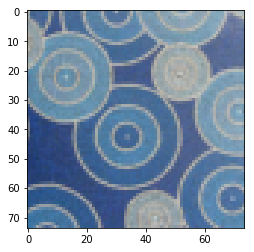

In [119]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(74),
    transforms.ToTensor(),
])

example_texture = img.image_loader("data/original/rings-2.jpg", transform)
img.show_image(example_texture)

In [205]:
importlib.reload(losses)
importlib.reload(shift)

vgg(example_texture)
target = stats.extract_features(hook_bag.get_hook("texture_hooks"), stats.gram_matrix)

def smooth_loss(_, sample_features):
    loss = 0
    for layer in sample_features:
        print(layer.numel())
        loss += losses.smoothing_loss(layer) * layer.numel()
        print("loss: {}".format(loss))
    return loss

smoothness_loss = loss.LossFn(None, hook_bag.get_hook("texture_hooks"), smooth_loss) 

In [206]:
collector = loss.LossCollector()
collector.add_loss_fn("texture", smoothness_loss)

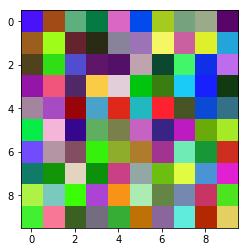

In [207]:
sample_texture = img.random_image(1, 100)
img.show_image(sample_texture[:, :, :10, :10])

inputs = {
    "input": sample_texture,
    "loss_name": "texture",
    "pyramid": False,
}

optimizer = optim.LBFGS([sample_texture])

In [208]:
stepper = closure.Stepper(inputs, vgg, collector, optimizer)

640000
tensor(887228.6875, device='cuda:0', grad_fn=<SumBackward0>)
loss: 3606.736328125
640000
tensor(887228.6875, device='cuda:0', grad_fn=<SumBackward0>)
loss: 3606.736328125
tensor([3.1995e-08, 4.1758e-08, 6.5585e-08], device='cuda:0')
640000
tensor(887228.6875, device='cuda:0', grad_fn=<SumBackward0>)
loss: 3606.736328125
640000
tensor(887228.6875, device='cuda:0', grad_fn=<SumBackward0>)
loss: 3606.736328125
tensor([ 1.0253e-07,  7.3962e-08, -3.2186e-08], device='cuda:0')
640000
tensor(887228.6875, device='cuda:0', grad_fn=<SumBackward0>)
loss: 3606.736328125
640000
tensor(887228.6875, device='cuda:0', grad_fn=<SumBackward0>)
loss: 3606.736328125
tensor([ 1.2245e-07,  6.0576e-08, -9.6935e-08], device='cuda:0')
640000
tensor(887228.6875, device='cuda:0', grad_fn=<SumBackward0>)
loss: 3606.736328125
640000
tensor(887228.6875, device='cuda:0', grad_fn=<SumBackward0>)
loss: 3606.736328125
tensor([ 1.0344e-07,  4.1470e-08, -1.3237e-07], device='cuda:0')
640000
tensor(887228.6875, devi

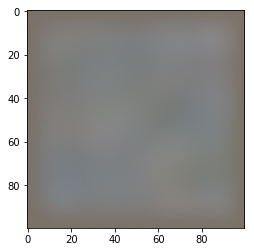

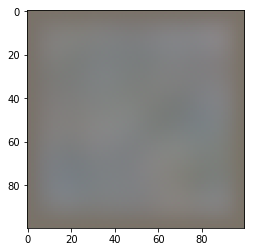

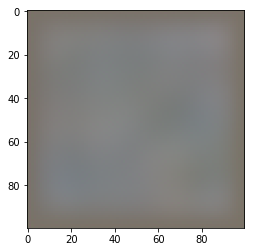

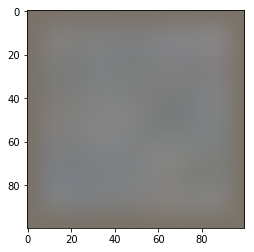

In [211]:
importlib.reload(stats)
importlib.reload(losses)

show_at = 1
for i in range(10):
    optimizer.step(stepper.loss_fn)
    
    if i == show_at:
        show_at *= 2
        img.show_image(sample_texture)
    print(sample_texture.grad[0][0][0][:3])